# Self-Driving Car Engineer Nanodegree

## Project: Traffic Sign Recognition Classifier

**Strategy:**

(1) Data preparation:
    - Whiten input data to zero mean
    - Apply data augmentation
(2) Network design:
    - Decide feature abstraction level according to problem complexity
    - Decide network layout based on image characteristics
(3) Regularization techniques:
    - Apply dropout out between FC layers
    - Apply L1 and L2 kernel regularizers
(4) Optimization techniques:
    - Choose optimizer and training hyperparameters
    - Apply batch-normalization and learning rate decay for better convergence
(5) Training evaluation
    - Evaluate overfitting on train and dev set
    - Test on new images

---
## 1. Data preparation
### 1.1 Load Dataset

Number of training examples = 34799
Number of testing examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


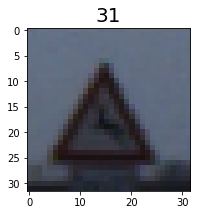

In [1]:
# Load dataset
import pickle
training_file   = "traffic_signs_data/train.p"
validation_file = "traffic_signs_data/valid.p"
testing_file    = "traffic_signs_data/test.p"
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Dataset Summary & Exploration
import numpy as np
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test ['features'], test['labels']
n_train      = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test       = X_test.shape[0]
n_classes    = len(np.unique(y_train))
img_shape    = X_train[0].shape
print("Number of training examples =", n_train)
print("Number of testing examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", n_classes)

# Visualizing one training sample
import matplotlib.pyplot as plt
%matplotlib inline
img_idx = 600
img_to_show = X_train[img_idx]
plt.figure(figsize=(img_to_show.shape[1], img_to_show.shape[2]))
plt.imshow(img_to_show)
plt.title(y_train[img_idx], fontsize=20)

### 1.2 Input data whitening

In [2]:
def preprocess(x):
    '''
    Whitening input.
    '''
    return (x-128.)/128.

### 1.3 Data augmentation
Traffic sign contains distinctive structure information, so usually excessive geometrical transform (such as flipping, mirroring, rotating, perspective or other affine transform) would not be appropriate.

Therefore, in this excerise, only basic data augmentation such as cropping, blurring, additive noise, and intensity adjustment are added.

In [3]:
# Define helper functions for data augmentation
import cv2

def add_gaussian_noise(images):
    '''
    Add normal distribution noise to images
    '''
    noisy_images = []
    for i in range(images.shape[0]):
        noise = np.random.normal(loc=0., scale=3.0, size=images[i].shape).astype(np.float32)
        noisy_images.append(images[i] + noise)
    return np.array(noisy_images, dtype=np.float32)

def apply_gaussian_blur(images):
    '''
    Apply blurring effect
    '''
    blur_images = []
    kernel_size = 5
    for i in range(images.shape[0]):
        blur_images.append(cv2.GaussianBlur(images[i], (kernel_size, kernel_size), 0))
    return np.array(blur_images, dtype=np.float32)

def add_salt_and_pepper(images):
    '''
    Add salt & pepper noise
    '''
    sp_images = images.copy()
    row, col, _ = images[0].shape
    sp_amount = 0.001
    num_salt   = np.ceil(sp_amount * images[0].size)
    num_pepper = np.ceil(sp_amount * images[0].size)
    for img in sp_images:
        # Add Salt & Pepper noise
        coords = [np.random.randint(0, i-1, int(num_salt)) for i in img.shape]     # Salt
        img[coords[0], coords[1], :] = 1
        coords = [np.random.randint(0, i-1, int(num_pepper)) for i in img.shape]   # Pepper
        img[coords[0], coords[1], :] = 0
        return np.array(sp_images, dtype=np.float32)

def crop_image(images):
    '''
    Crop image and resize it back
    '''
    border_ratio = 0.1
    row, col, _ = images[0].shape
    height_crop = np.ceil(row * border_ratio)
    width_crop  = np.ceil(col * border_ratio)
    crop_images = []
    for img in images:
        # Get random crop size
        start_y = np.random.randint(0, height_crop)
        end_y   = np.random.randint(row-height_crop-1, row-1)
        start_x = np.random.randint(0, width_crop)
        end_x   = np.random.randint(col-width_crop-1, col-1)
        crop_images.append(cv2.resize(img[start_y:end_y, start_x:end_x], (row, col)))
    return np.array(crop_images, dtype=np.float32)

def adjust_intensity(images):
    '''
    Adjust intensity of image to mimic lighting conditions
    '''
    min_ratio = 0.8
    max_ratio = 1.1
    adjusted_images = []
    for img in images:
        # Get random adjustment ratio
        ratio = np.random.uniform(min_ratio, max_ratio)
        adjusted_images.append(img * ratio)
    return np.array(adjusted_images, dtype=np.float32)

def data_augmentation(images):
    '''
    Apply online data augmentation
    '''
    da_ratio   = 0.9
    if(np.random.uniform() > da_ratio):              # Apply data augmenation
        if(np.random.uniform() > 0.5):               # Crop image:
            images = crop_image(images)
        if(np.random.uniform() > 0.5):               # Apply blurring effect:
            images = apply_gaussian_blur(images)
        if(np.random.uniform() > 0.5):               # Add noise
            if(np.random.uniform() > 0.5):
                images = add_gaussian_noise(images)  # Gaussian noise
            else:
                images = add_salt_and_pepper(images) # Salt & Pepper noise
        if(np.random.uniform() > 0.5):               # Adjust intensity
            images = adjust_intensity(images)
    return images


### 1.4 Data feeding
During the training, data are to be shuffled for each epoch so that the model would memorize less the training pattern. Python feed dictionary is used since we have a relatively small dataset.

In [4]:
# Define data feeding helper functions
def shuffle_data(images, labels):
    '''
    Shuffe the data, and label accordingly
    '''
    idx = np.random.permutation(len(labels))
    return images[idx,:,:,:], labels[idx]

def next_batch(X, y, idx, batch_size, n_classes):
    '''
    Return next batch images and their one-hot labels
    '''
    batch_x = np.asarray(X[idx*batch_size : (idx+1)*batch_size, :, :, :], dtype=float)
    batch_y = np.zeros((batch_size, n_classes))
    y_label = y[idx*batch_size : (idx+1)*batch_size]                                 
    for i in range(batch_size):
        batch_y[i][y_label[i]] = 1.
    return batch_x, batch_y

---

## 2 Network Design

### 2.1 Decide feature abstraction level according to problem complexity

A 3-layer CNN is used based on the following intuition:
- First conv layer is responsible for primiary feature extraction, such as edges.
- Second conv layer is responsible for combinations of primary features, such as corners.
- Third conv layer makes structural descriptors by combining previous featurs, such as shape-context, or SIFT-type descriptor.

Due to the nature of traffic sign design, only distinctive structrual information is used, so further stacking on conv layers would propbably create overwhelming description power so that the model might overfit the training set. 

Therefore, in this excercise, only 3 conv layers are stacked followed by fully-connected layers as classifier.

### 2.2 Analyze image characteristics to setup network layout

The width of network is defined based on the following input data analysis:
- Conv1 intuition:
    - Color information would be essential since different color information usually indicates different conditions. So color input format is kept.
    - Simple structrial information is supposed to be the essence of traffic sign design, so 4 primary orientations for feature detection would be sufficient.
    - Since input image is small(32x32), a 5x5 kernel is used to collect local spatial information, and no stride would be necessary.
    - combining color channel cross-correlation, 12 hidden units (i.e. 3x4) are used in first conv layer.

- Conv2 intuition:
    - Smaller kernel is applied (3x3) due to reduced neighborhood.
    - Stacking 2 conv layers (3x3) would give an effective receptive field of (5x5), so no immediate pooling is effectuated. 
    - After conv1 (with pooling), data volum is: 14x14x12=2350, to keep similar data throughput, 16 hidden units are used which gives 12x12x16=2304.
    
- Conv3 intuition:
    - Used 24 hidden units to keep data throughput (10x10x24=2400)
    - Pooling for data reduction to avoid too mnay connection in FC layer
   
- Fully connected layer intuition:
    - Applied 3 FC layers in order to have 2 chances of dropout application which helps to generalize model in test data
    - Gradually boil down data from 600 hidden units(after flattening) to 256, then to 128, then to 43 classes of traffic sign.
    
>*Regularization techniques(dropout and kernel regularizer) are integrated into network.

>*Optimization technique(batch-norm) is integrated as well.

In [5]:
# Define network
def conv_block(inputs, filters, kernel_size, reg_param, train_flag, pool_flag):
    '''
    Building block: conv --> Batch Norm --> Relu --> (optional) pool
    '''
    x = tf.layers.conv2d(inputs = inputs, filters = filters, kernel_size = kernel_size, activation = None, 
                         kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(reg_param))
    x = tf.layers.batch_normalization(inputs = x, training = train_flag)
    x = tf.nn.relu(x)
    if(pool_flag):
        x = tf.layers.max_pooling2d(inputs = x, pool_size = (2,2), strides = (2,2))
    return x

def dense_block(inputs, units, reg_param, dropout_flag=False, dropout_rate=0., train_flag=False):
    '''
    Building block: fully-connected --> (optional) dropout
    '''
    x = tf.layers.dense(inputs = inputs, units = units, activation = tf.nn.relu,
                        kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(reg_param))
    if(dropout_flag):
        x = tf.layers.dropout(inputs = x, rate = dropout_rate, training = train_flag)
    return x
      
def TrafficSignCnn(x, n_classes, dropout_rate=0.5, train_flag=False, reg_param=1.):
    '''
    Traffic sign classification CNN.
    '''
    conv1 = conv_block(x,     12, (5,5), reg_param, train_flag, pool_flag=True)  # (1) Conv-->BN-->Relu-->Pool
    conv2 = conv_block(conv1, 16, (3,3), reg_param, train_flag, pool_flag=False) # (2) Conv-->BN-->Relu
    conv3 = conv_block(conv2, 24, (3,3), reg_param, train_flag, pool_flag=True)  # (3) Conv-->BN-->Relu
    x = tf.contrib.layers.flatten(inputs = conv3)                                #     Flatten
    x = dense_block(x, 256, reg_param, True, dropout_rate, train_flag)           # (6) FC6 with dropout
    x = dense_block(x, 128, reg_param, True, dropout_rate, train_flag)           # (7) FC7 with dropout
    x = dense_block(x, n_classes, reg_param)                                     # (8) logits
    return conv1, conv2, conv3, x

def cnn(x, input_shape, n_classes, dropout_rate=0., train_flag=False, reg_param=1.):
    '''
    Define architecture of CNN model.
    '''
    # Preprocess input
    x = tf.reshape(x, (-1, input_shape[0], input_shape[1], input_shape[2]))
    x = preprocess(x)

    # Define graph
    conv1, conv2, conv3, x = TrafficSignCnn(x, n_classes, dropout_rate, train_flag, reg_param)
    return conv1, conv2, conv3, x

---
## 3 Training and Evaluating

### 3.1 Define Training Operation

- hyper-parameter setup
- optimizer selection
- training step definition
- evaluation metric defintion

In [6]:
import tensorflow as tf

# Define hyper parameters
LEARNING_RATE  = 0.001      # initial learning rate
LR_DECAY_STEP  = 100        # learning rate decay step
LR_DECAY_RATIO = 0.1        # learning rate decay ratio
BATCH_SIZE     = 512        # mini-batch size
EPOCHS         = 300        # training epochs
DROPOUT_RATE   = 0.5        # dropout rate
REG_PARAM      = 1.0        # kernel regularizer param

# Allocate placeholder for input feature and its label
x  = tf.placeholder(tf.float32, (None, img_shape[0], img_shape[1], img_shape[2]))
y  = tf.placeholder(tf.float32, (None, n_classes))
lr = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)

# Define loss computation
conv1, conv2, conv3, logits = cnn(x, img_shape, n_classes, dropout_rate, True, REG_PARAM)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Select optimizer and define training step
opt = tf.train.AdamOptimizer(learning_rate=lr)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Update for batch-norm(get global moving mean&variance status)
with tf.control_dependencies(update_ops):
    train_op = opt.minimize(loss_op)

# Define performance metric: accuray computation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

d:\python\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### 3.2 Effectuate Training Process

- Create saver for model export
- Define evaluation process
- Training the network

In [7]:
# Create saver
TRAINING_FLAG      = False     # Turn this to True for re-training
CONTINUED_TRAINING = False     # Turn this to True for continued training
CONTINUED_MODEL    = './TrafficSignModel.ckpt'
INFERENCING_MODEL  = './trained_model/TrafficSignModel.ckpt'
saver = tf.train.Saver()

# Define evaluation helper
def eval_data(sess, x_eval, y_eval, batch_size, n_classes):
    '''
    Evaluate model prediction performance.
    '''
    steps_per_epoch = x_eval.shape[0] // batch_size
    num_examples = steps_per_epoch * batch_size
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = next_batch(x_eval, y_eval, step, batch_size, n_classes)
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x:batch_x, y:batch_y, dropout_rate:0.})
        total_acc  += (acc  * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

## Train & Evalute
# Initialize global variables 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
   
# Train model
if(TRAINING_FLAG):
    # Load previously trained model if necessary
    if(CONTINUED_TRAINING):
        saver.restore(sess, CONTINUED_MODEL)
    
    # Compute number of batches
    steps_per_epoch = n_train // BATCH_SIZE

    learning_rate = LEARNING_RATE
    print("\nCurrent learning rate: {}".format(learning_rate))
    for i in range(EPOCHS):
        # Shuffle training set for each epoch:
        X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)

        # Mini-batch training
        for step in range(steps_per_epoch):
            # Get a mini-batch
            batch_x, batch_y = next_batch(X_train_shuffle, y_train_shuffle, step, BATCH_SIZE, n_classes)
            
            # Add data augmentation on training set
            batch_x = data_augmentation(batch_x)
            
            # Train and feedback loss and acc
            loss, acc, _ = sess.run([loss_op, accuracy_op, train_op], feed_dict={x:batch_x, y:batch_y, 
                                                                                 lr:learning_rate, dropout_rate:DROPOUT_RATE})
            print("\rEpoch {}:\ttrain_loss: {:.4f}   train_acc = {:.4f}\t".format(i+1, loss, acc), end='')

        # Evaluate at the end of each epoch
        val_loss, val_acc = eval_data(sess, X_valid, y_valid, BATCH_SIZE, n_classes)
        print("   val_loss: {:.4f}   val_acc = {:.4f} \n".format(val_loss, val_acc), end='')

        if((i+1)==EPOCHS):
            # Save trained model when training finishes
            _ = saver.save(sess, './TrafficSignModel.ckpt')
        else:
            # Learning rate decay:
            if ((i+1) % LR_DECAY_STEP == 0):
                # Decay learning rate and save a ckpt.
                learning_rate *= LR_DECAY_RATIO
                _ = saver.save(sess, './Epoch_'+str(i+1)+'.ckpt')
                print("\nCurrent learning rate: {}".format(learning_rate))
else:         
    # Load previously trained model
    saver.restore(sess, INFERENCING_MODEL)
    
# Verify accuracy on test set
test_loss, test_acc = eval_data(sess, X_test, y_test, BATCH_SIZE, n_classes)
print("\nEvaluate on full test data:")
print("test_loss: {:.4f}   test_acc = {:.4f} \n".format(test_loss, test_acc))

INFO:tensorflow:Restoring parameters from ./trained_model/TrafficSignModel.ckpt

Evaluate on full test data:
test_loss: 0.1271   test_acc = 0.9740 



## 4. Deploy Model on New Images

New test images are downloaded from [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). Each time, 9 random images will be drawn from first 1000 images to test performance of the trained model.


Image No1: 5 possible candidates are:
(1)Wild animals crossing: confidence is 1.0000
(2)Slippery road: confidence is 0.0000
(3)Double curve: confidence is 0.0000
(4)Bumpy road: confidence is 0.0000
(5)Road work: confidence is 0.0000

Image No2: 5 possible candidates are:
(1)Speed limit (60km/h): confidence is 0.6134
(2)Yield: confidence is 0.1129
(3)Speed limit (80km/h): confidence is 0.1000
(4)No vehicles: confidence is 0.0510
(5)Speed limit (30km/h): confidence is 0.0197

Image No3: 5 possible candidates are:
(1)No passing for vehicles over 3.5 metric tons: confidence is 0.9998
(2)No passing: confidence is 0.0001
(3)Speed limit (100km/h): confidence is 0.0000
(4)Speed limit (80km/h): confidence is 0.0000
(5)Vehicles over 3.5 metric tons prohibited: confidence is 0.0000

Image No4: 5 possible candidates are:
(1)Stop: confidence is 0.9999
(2)Yield: confidence is 0.0001
(3)No entry: confidence is 0.0000
(4)Speed limit (30km/h): confidence is 0.0000
(5)Speed limit (60km/h): confidence i

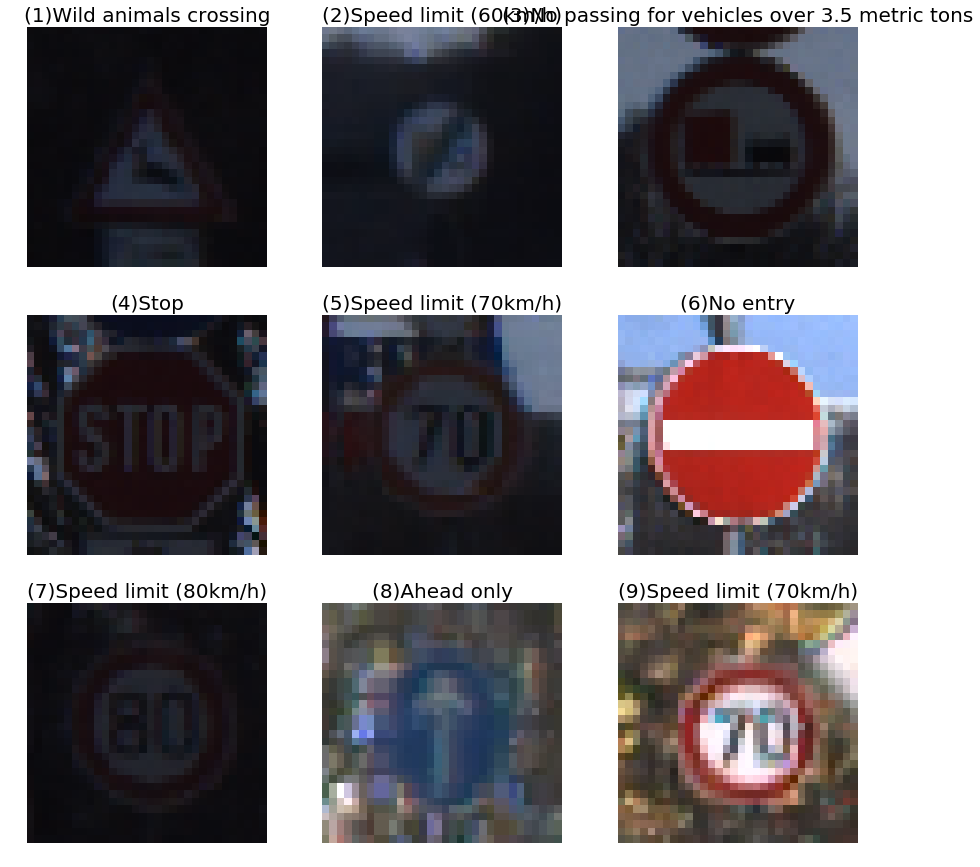

In [8]:
def get_sign_name():    
    '''
    Get name description of each sign
    '''
    import csv
    sign_names = []
    with open('signnames.csv', newline='') as f:
        all_lines = csv.reader(f, delimiter=',')
        next(all_lines)    # Skip header
        for line in all_lines:
            sign_names.append(line[1])
    return sign_names

def predict_one_sample(sess, img):
    '''
    Run feed forward on one image sample
    '''
    loss = sess.run(logits, feed_dict={x:img.reshape((1,32,32,3)), dropout_rate:0.})
    match_prob   = sess.run(tf.nn.softmax(np.array([loss[0]])))
    predictions  = np.squeeze(match_prob)
    #top_5 = predictions.argsort()[-5:][::-1]
    top_5 = sess.run(tf.nn.top_k(tf.constant(predictions), k=5))
    return conv1, conv2, conv3, top_5

def print_top_k(img_idx, top_k, sign_names):
    '''
    Print top k candidates for each prediction.
    '''
    print('\nImage No{}: {} possible candidates are:'.format(img_idx+1, len(top_k[0])))
    for i in range(len(top_k[0])):
        print('({}){}: confidence is {:.4f}'.format(i+1, sign_names[top_k[1][i]], top_k[0][i]))    
        
# Get sign names
sign_names = get_sign_name()

# Make predictions on new test images
from PIL import Image
num_new_images = 9
test_image_idx = np.random.randint(0, 1000, num_new_images)
plt.figure(figsize=(15, 15))
for i in range(num_new_images):
    # Resize if image
    img_name = 'new_test_images/' + str(test_image_idx[i]).zfill(5) + '.ppm'
    img = np.array(Image.open(img_name).resize((32,32)))
    
    # Run prediction
    conv1, conv2, conv3, top_5 = predict_one_sample(sess, img)
    print_top_k(i, top_5, sign_names)
    
    # Plot mosaic
    plt.subplot(3,3, i+1)
    plt.imshow(img)
    plt.title('({}){}'.format(i+1, sign_names[top_5[1][0]]), fontsize=20)
    plt.axis('off')

## 5. (Optional) Visualization of Activation Map

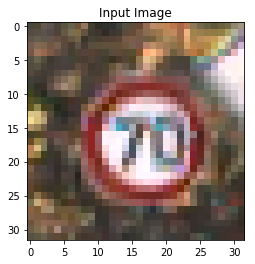

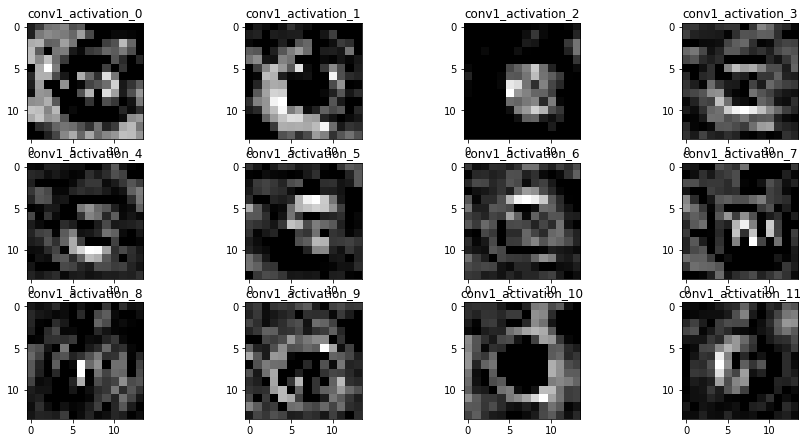

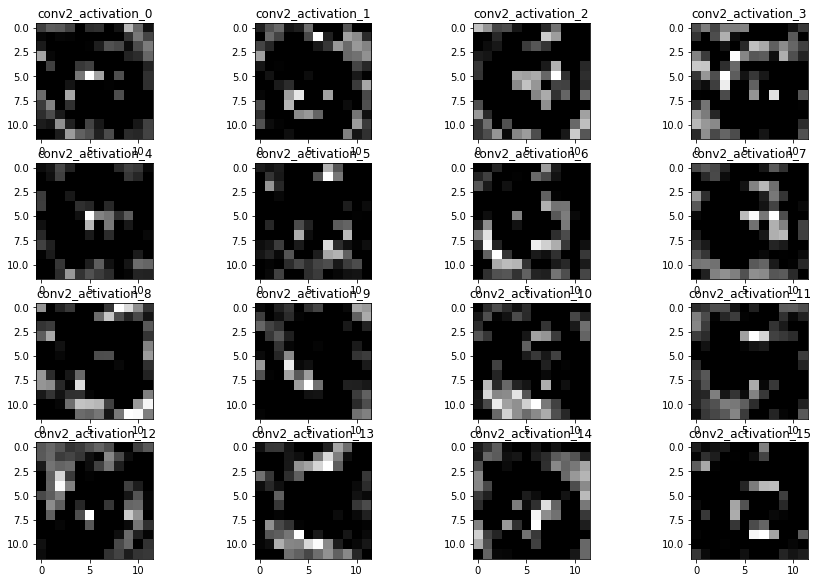

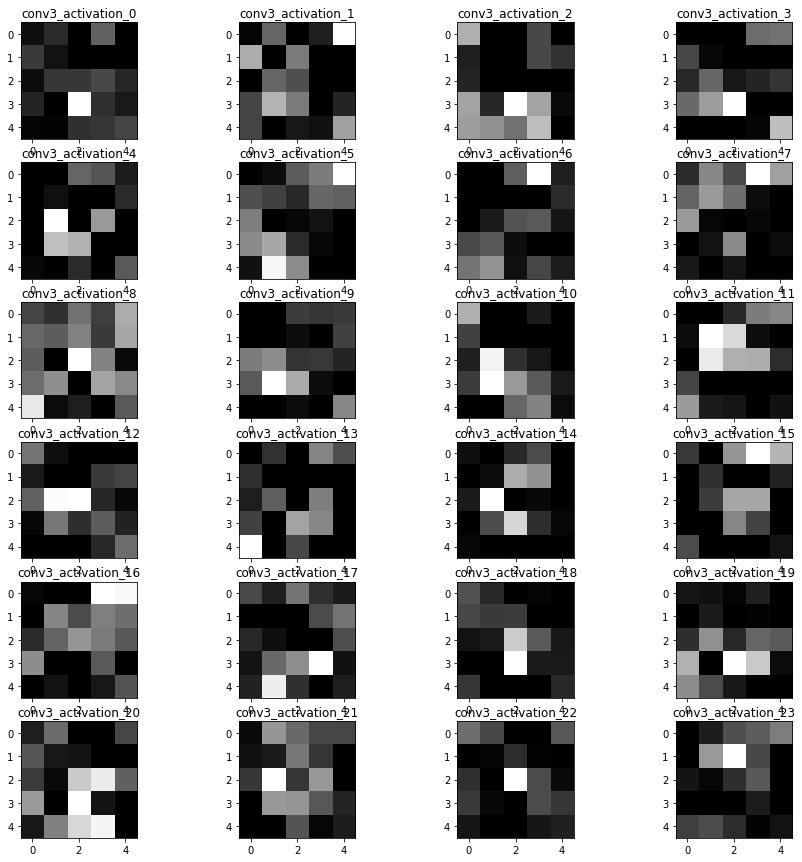

In [9]:
def visualize_activation(layer_output, layer_idx):
    '''
    Visualization of activation map
    '''
    num_kernel = layer_output.shape[3]
    plt.figure(figsize=(15,15))
    for i in range(num_kernel):
        plt.subplot(6,4, i+1)
        plt.imshow(layer_output[0, :, :, i], interpolation="nearest", cmap="gray")
        plt.title('conv{}_activation_{}'.format(layer_idx, i))

# Evaluate conv layer outputs
conv1, conv2, conv3 = sess.run([conv1, conv2, conv3], feed_dict={x:img.reshape((1,32,32,3)), dropout_rate:0.})
plt.imshow(img)
plt.title('Input Image')
visualize_activation(conv1, 1)
visualize_activation(conv2, 2)
visualize_activation(conv3, 3)

In [10]:
# Close the opening session.
sess.close()